#### Follow the tutorial material from Kaggle (use TF-IDF instead)
* 1-gram
* 5000 words

In [1]:
import warnings
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

warnings.filterwarnings("ignore")
%matplotlib inline

# Read data

In [2]:
train = pd.read_csv('./labeledTrainData.tsv', delimiter='\t', quoting=3)
test = pd.read_csv('./testData.tsv', delimiter='\t', quoting=3)

# get the number of training and test examples
n_train = len(train)
n_test = len(test)

# Data Cleaning and Processing

In [3]:
def review2words(review):
    """ function to convert input review into string of words """
    # Remove HTML
    review_text = BeautifulSoup(review, 'lxml').get_text() 

    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 

    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                             

    # Join the words and return the result.
    return " ".join(words)

# get train label
train_y = train['sentiment'].values

# transform reviews into words list
train_review = list(map(review2words, train['review']))
test_review = list(map(review2words, test['review']))

# combine train and test reviews
all_review = train_review + test_review

# perform TF-IDF transformation
vectorizer = TfidfVectorizer(min_df=3, analyzer="word", strip_accents='unicode', 
                             sublinear_tf=True, stop_words='english', 
                             max_features=5000, ngram_range=(1, 1)) 

# fit and transform the data
all_features = vectorizer.fit_transform(all_review)

# trainsform into array
train_features = all_features[:n_train, :].toarray()

# Logistic Regression with Ridge Penalty

In [4]:
# fit the Logistic model
logit2 = LogisticRegression(penalty='l2', tol=0.0001, C=2.7825549, random_state=2017, 
                            solver='liblinear', n_jobs=-1, verbose=0)
logit2 = logit2.fit(train_features, train_y)

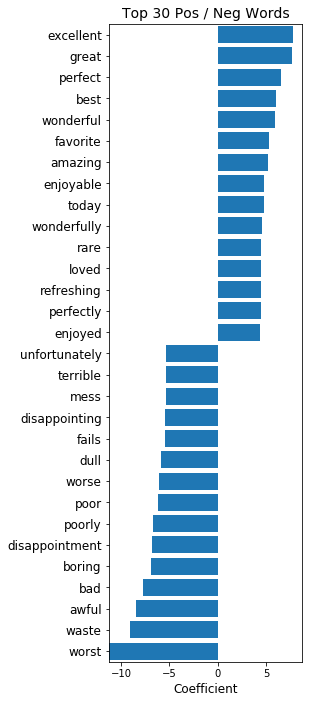

In [35]:
# find all the words used
words = np.array(vectorizer.get_feature_names())
logit2coef = logit2.coef_[0, :]

# make importances relative to max importance
sorted_idx = np.argsort(logit2coef, kind='mergesort')
pos = np.arange(len(sorted_idx)) + 0.5

# plot the relative importance
N = 15
idx = np.concatenate((sorted_idx[:N], sorted_idx[-N:]))

fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(pos[:2 * N], logit2coef[idx], align='center')
ax.set_ylim([0, N * 2])
plt.yticks(pos[: 2 * N], words[idx], fontsize=12)
plt.tight_layout(pad=3.08, h_pad=None, w_pad=None, rect=None)
ax.set_xlabel('Coefficient', fontsize=12)
ax.set_title('Top {0} Pos / Neg Words'.format(2 * N), fontsize=14)
plt.savefig('./top_words.png', dpi=200)
plt.show()

# Logistic Regression with Lasso

In [79]:
# fit the Logistic model
logit1 = LogisticRegression(penalty='l1', tol=0.0001, C=2.7825549, random_state=2017, 
                            solver='liblinear', n_jobs=-1, verbose=0)
logit1 = logit1.fit(train_features, train_y)

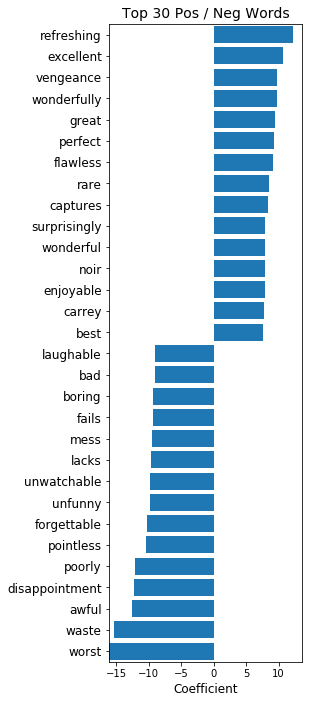

In [81]:
# find all the words used
words = np.array(vectorizer.get_feature_names())
logit1coef = logit1.coef_[0, :]

# make importances relative to max importance
sorted_idx = np.argsort(logit1coef, kind='mergesort')
pos = np.arange(len(sorted_idx)) + 0.5

# plot the relative importance
N = 15
idx = np.concatenate((sorted_idx[:N], sorted_idx[-N:]))

fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(pos[:2 * N], logit1coef[idx], align='center')
ax.set_ylim([0, N * 2])
plt.yticks(pos[: 2 * N], words[idx], fontsize=12)
plt.tight_layout(pad=3.08, h_pad=None, w_pad=None, rect=None)
ax.set_xlabel('Coefficient', fontsize=12)
ax.set_title('Top {0} Pos / Neg Words'.format(2 * N), fontsize=14)
plt.show()

# Random Forest Model

In [26]:
# Initialize a Random Forest classifier
forest = RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=2017, 
                                oob_score=True, max_features='auto') 

# Fit the forest to the training set
forest = forest.fit(train_features, train_y)

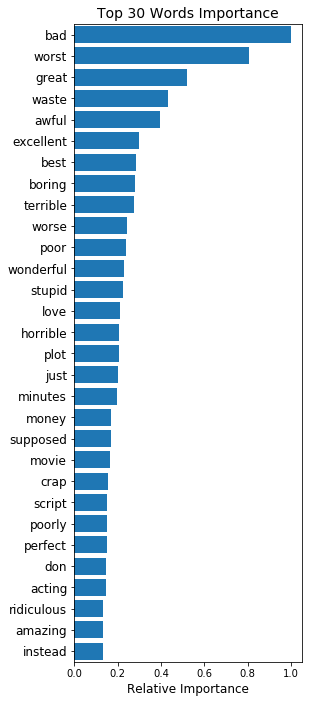

In [27]:
# find all the words used
words = np.array(vectorizer.get_feature_names())
importance = forest.feature_importances_

# make importances relative to max importance
importance = importance / importance.max()
sorted_idx = np.argsort(importance, kind='mergesort')
pos = np.arange(len(sorted_idx)) + 0.5

# plot the relative importance
N = 30
fig, ax = plt.subplots(figsize=(5, 10))
ax.barh(pos[:N], importance[sorted_idx[-N:]], align='center')
ax.set_ylim([0, N])
plt.yticks(pos[:N], words[sorted_idx[-N:]], fontsize=12)
plt.tight_layout(pad=3.08, h_pad=None, w_pad=None, rect=None)
ax.set_xlabel('Relative Importance', fontsize=12)
ax.set_title('Top {0} Words Importance'.format(N), fontsize=14)
plt.savefig('./importance.png', dpi=200)
plt.show()

# Define Positive and Negative Words

In [87]:
# find all the words used
words = np.array(vectorizer.get_feature_names())

# get coefficients and importance
logit1coef = logit1.coef_[0, :]
logit2coef = logit2.coef_[0, :]
importance = forest.feature_importances_
importance = importance / importance.max()

# make importances relative to max importance
logit1_idx = np.argsort(logit1coef, kind='mergesort')
logit2_idx = np.argsort(logit2coef, kind='mergesort')
forest_idx = np.argsort(importance, kind='mergesort')

In [ ]:
# define positive and negative words for eath model
N = 200
logit1_neg = words[logit1_idx][:N]
logit1_pos = words[logit1_idx][-N:]

logit2_neg = words[logit2_idx][:N]
logit2_pos = words[logit2_idx][-N:]

forest_imp = words[forest_idx][-(2 * N):]

# fine common words in both model
pos_words = list(set(logit1_pos) & set(logit2_pos) & set(forest_imp))
neg_words = list(set(logit1_neg) & set(logit2_neg) & set(forest_imp))

In [172]:
# define positive and negative words for eath model
N = 200
logit1_neg = words[logit1_idx][:N]
logit1_pos = words[logit1_idx][-N:]

logit2_neg = words[logit2_idx][:N]
logit2_pos = words[logit2_idx][-N:]

# fine common words in both model
pos_words = list(set(logit1_pos) & set(logit2_pos))
neg_words = list(set(logit1_neg) & set(logit2_neg))

In [173]:
print(pos_words)
print(neg_words)
print(len(pos_words))
print(len(neg_words))

['realistic', 'bravo', 'enjoyable', 'victoria', 'solid', 'appreciated', 'wonderful', 'available', 'innocent', 'enjoy', 'surprised', 'elvira', 'loved', 'powerful', 'packed', 'steals', 'friendship', 'outstanding', 'apartment', 'daniel', 'tight', 'troubled', 'highly', 'worlds', 'erotic', 'love', 'definitely', 'fears', 'rare', 'underrated', 'discovers', 'cool', 'pleasantly', 'matthau', 'chilling', 'marvelous', 'jack', 'focuses', 'masterpiece', 'plenty', 'perfect', 'superb', 'timeless', 'especially', 'quiet', 'extraordinary', 'humour', 'tears', 'draws', 'unique', 'seen', 'vhs', 'simple', 'finest', 'subtle', 'classic', 'best', 'spring', 'bound', 'succeeds', 'superbly', 'believable', 'incredible', 'tony', 'release', 'marie', 'joan', 'fashioned', 'jackie', 'dirty', 'strong', 'knowing', 'noir', 'builds', 'scared', 'amazing', 'easy', 'ride', 'entertaining', 'world', 'touching', 'moving', 'liked', 'heart', 'bourne', 'today', 'soccer', 'disagree', 'eerie', 'wonderfully', 'good', 'favorite', 'sweet

# Visualization

In [182]:
# read file
text = pd.read_csv('./testData.tsv', delimiter='\t', quoting=3)[:50]

In [183]:
# defind the head of the html file
start_string = """
<!DOCTYPE html>
<html>
<head>
<style>@import "textstyle.css"</style>
</head>
<body>
<h1 align="middle">Movie Review Visualization</h1> 
<h3 align="middle"> STAT 542 Project 4 Part II, by Jifu Zhao & Jinsheng Wang </h2>
<h2> 1. Top Positive and Negative Words</h2>
<div>
<img src="./top_words.png" width=40%>
<img src="./importance.png" width=40%>
</div>
<p>
&ensp;&ensp;&ensp;&ensp; The above figures are generated from Logistic Regression 
with Ridge Penalty and Random Forest model
</p><br>
<h2> 2. Detailed Text Analysis</h2>
"""

In [184]:
# process and write to html file
with open('./sample_visualization.html', 'w') as f:
    f.write(start_string)
    f.write('<ul>\n')
    
    for num in range(len(text)):
        idx = text['id'][num][1:-1]
#         sentiment = text['sentiment'][num]
        
        # split and replace the review words
        tmp_text = text['review'][num][1:-1]
        tmp_text = tmp_text.replace('\\', '')
        tmp_text = BeautifulSoup(tmp_text, 'lxml').get_text()
        # add space after comma that has no space
        tmp_text = re.sub(r'([,]+)(?![ ])', r'\1 ', tmp_text)
        tmp_text = tmp_text.split(' ')
        
        # write the header part of each review
        f.write('<hr>\n&ensp;')
        f.write('<strong> id: </strong> ' + str(idx) + ' &emsp; &emsp;\n')
#         f.write('<strong> sentiment: </strong>' + str(sentiment) + ' <br>\n')
        f.write('<hr>\n')
        
        # find all the indexes for the positive and negative words
        pos_idx = []
        neg_idx = []
        for word in pos_words:
            # regular pattern match
            regex = re.compile('.*(' + word + ').*', re.IGNORECASE)
            regex = re.compile('\\b' + word + '.*', re.IGNORECASE)
            pos_idx += [i for i in range(len(tmp_text)) if regex.search(tmp_text[i])]
        
        for word in neg_words:
            # regular pattern match
            regex = re.compile('.*(' + word + ').*', re.IGNORECASE)
            regex = re.compile('\\b' + word + '.*', re.IGNORECASE)
            neg_idx += [i for i in range(len(tmp_text)) if regex.search(tmp_text[i])]
            
        # replace all positive words with pre-defined html class
        for i in pos_idx:
            tmp_text[i] = '<span class="pos">' + tmp_text[i] + '</span>'
            
        # replace all negative words with pre-defined html class
        for i in neg_idx:
            tmp_text[i] = '<span class="neg">' + tmp_text[i] + '</span>'
            
        # write into html file
        f.write(' '.join(tmp_text))  
        f.write('\n<br><br>\n\n')
        
    # end of the html file
    f.write('</ul>\n</body>\n</html>\n')